### Skeleton code 

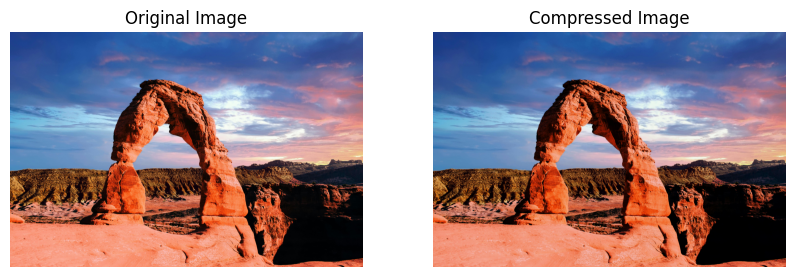

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# loading an image
img = Image.open('canyon.jpg')  # Replace with your image path
img = img.convert('RGB')  # Ensure it's RGB
img_array = np.array(img)

#   compress one channel
def compress_channel(channel, wavelet='haar', level=2, threshold=20):
    coeffs = pywt.wavedec2(channel, wavelet=wavelet, level=level)
    coeffs_thresh = []
    for c in coeffs:
        if isinstance(c, tuple):
            c_thresh = tuple(pywt.threshold(subband, threshold, mode='soft') for subband in c)
            coeffs_thresh.append(c_thresh)
            #print(c_thresh)
        else:
            coeffs_thresh.append(pywt.threshold(c, threshold, mode='soft'))
            #print(c)
    reconstructed = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
    return np.clip(reconstructed, 0, 255)

# applying compression to each channel
compressed_channels = []
for i in range(3):  # R, G, B
    compressed = compress_channel(img_array[:, :, i])
    compressed_channels.append(compressed)

# stacking layetrs  back into an image
compressed_img = np.stack(compressed_channels, axis=2).astype(np.uint8)

# plt 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Compressed Image')
plt.imshow(compressed_img)
plt.axis('off')
plt.show()


## Coefficient choice added, and analysis of image size according to coefficient ratio kept 

Original file size: 3454.7 KB

ratio = 0.10  |  kept 10.00%  coeffs  |  file =  940.7 KB ( 27.2% of original)  → canyon_ratio_10.jpg
ratio = 0.20  |  kept 20.02%  coeffs  |  file = 1019.6 KB ( 29.5% of original)  → canyon_ratio_20.jpg
ratio = 0.30  |  kept 30.01%  coeffs  |  file = 1071.3 KB ( 31.0% of original)  → canyon_ratio_30.jpg
ratio = 0.60  |  kept 60.45%  coeffs  |  file = 1127.5 KB ( 32.6% of original)  → canyon_ratio_60.jpg
ratio = 0.80  |  kept 80.17%  coeffs  |  file = 1134.2 KB ( 32.8% of original)  → canyon_ratio_80.jpg


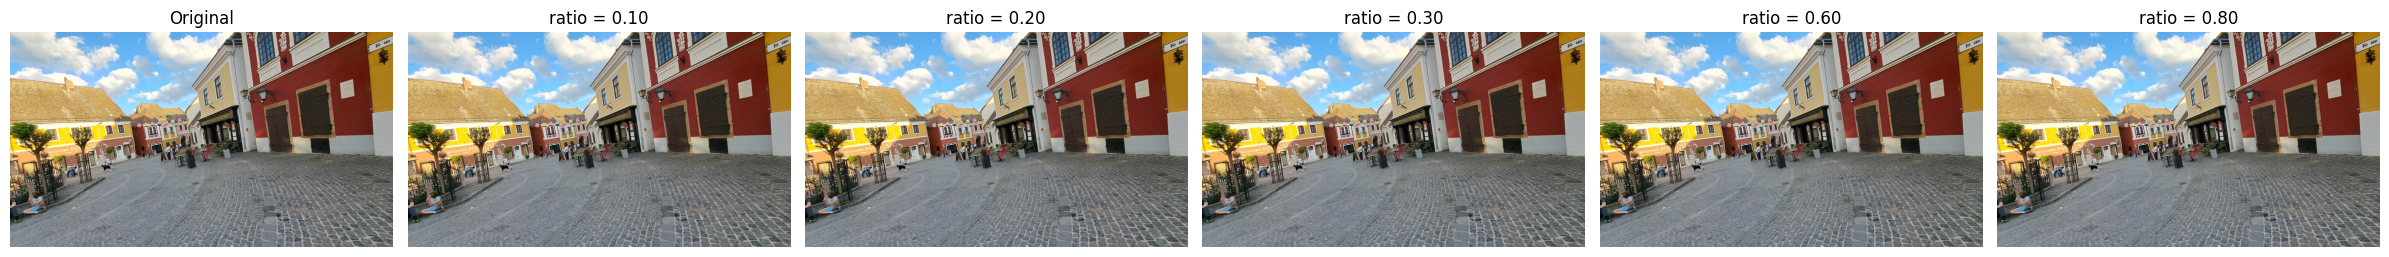

In [8]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image

# ------------------- GLOBAL SETTINGS -------------------
image_path = "szentendre.jpg"           # input 
wavelet     = "haar"
level       = 2
ratios      = [0.1, 0.2, 0.3, 0.6, 0.8]       # fraction of coefficients to keep
jpeg_quality = 60                   # jpg. , jpeg.  quality used when saving
# -----------------------------------------------------

def compress_channel_by_ratio(channel, ratio, wavelet="haar", level=2):
    """
    in short 
    
    keep the largest `ratio` fraction of wavelet coefficients in |channel|.
    Return the reconstructed channel, (# kept, # total) coefficient counts.
    
    """
    coeffs            = pywt.wavedec2(channel, wavelet=wavelet, level=level)
    coeff_array, slcs = pywt.coeffs_to_array(coeffs)
    total_coeffs      = coeff_array.size

    #  magnitude threshold due to which  exactly n_keep coefficients survive
    n_keep   = max(1, int(total_coeffs * ratio))
    flat_abs = np.abs(coeff_array).ravel()
    thresh   = np.partition(flat_abs, -n_keep)[-n_keep]   # O(N)
    kept_mask = np.abs(coeff_array) >= thresh
    coeff_array_pruned = np.where(kept_mask, coeff_array, 0)

    #  channel reconst. 
    coeffs_pruned = pywt.array_to_coeffs(coeff_array_pruned, slcs,
                                         output_format="wavedec2")
    rec = pywt.waverec2(coeffs_pruned, wavelet=wavelet)
    rec = np.clip(rec, 0, 255)

    kept_count = kept_mask.sum()
    return rec.astype(np.float32), kept_count, total_coeffs

# ---------- loading image for our experiment ----------
orig_img = Image.open(image_path).convert("RGB")
orig_arr = np.asarray(orig_img, dtype=np.float32)
orig_filesize = os.path.getsize(image_path)

# ---------- iterating through ratios ----------
results = []           # store stats for printing
gallery = [orig_img]   # first element: original

for ratio in ratios:
    kept_tot = 0
    tot_tot  = 0
    rec_channels = []

    for ch in range(3):                    # R, G, B
        rec_ch, kept, tot = compress_channel_by_ratio(orig_arr[:, :, ch],
                                                      ratio,
                                                      wavelet, level)
        rec_channels.append(rec_ch)
        kept_tot += kept
        tot_tot  += tot

    # merge channels and save
    rec_img = np.stack(rec_channels, axis=2).astype(np.uint8)
    out_name = f"canyon_ratio_{int(ratio*100):02d}.jpg"
    Image.fromarray(rec_img).save(out_name, format="JPEG", quality=jpeg_quality)
    out_size = os.path.getsize(out_name)

    results.append({
        "ratio"  : ratio,
        "kept"   : kept_tot,
        "total"  : tot_tot,
        "filesize" : out_size,
        "filename" : out_name
    })
    gallery.append(rec_img)

# ---------- report ----------
print(f"Original file size: {orig_filesize/1024:.1f} KB\n")
for r in results:
    pct_coeff = 100 * r["kept"] / r["total"]
    pct_size  = 100 * r["filesize"] / orig_filesize
    print(f"ratio = {r['ratio']:.2f}  |  kept {pct_coeff:5.2f}%  "
          f"coeffs  |  file = {r['filesize']/1024:6.1f} KB "
          f"({pct_size:5.1f}% of original)  → {r['filename']}")

# ---------- quick visual comparison ----------
cols = len(gallery)
plt.figure(figsize=(4 * cols, 4))
titles = ["Original"] + [f"ratio = {r:.2f}" for r in ratios]
for i, (img, title) in enumerate(zip(gallery, titles), 1):
    plt.subplot(1, cols, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image

# ------------------- GLOBAL SETTINGS -------------------
image_path = "szentendre.jpg"           # input 
wavelet     = "db2"  
level       = 2
ratios      = [0.1, 0.2, 0.3, 0.6, 0.8]       # fraction of coefficients to keep
jpeg_quality = 60                   # jpg. , jpeg.  quality used when saving
# -----------------------------------------------------

def compress_channel_by_ratio(channel, ratio, wavelet="haar", level=2):
    """
    in short 
    
    keep the largest `ratio` fraction of wavelet coefficients in |channel|.
    Return the reconstructed channel, (# kept, # total) coefficient counts.
    
    """
    coeffs            = pywt.wavedec2(channel, wavelet=wavelet, level=level)
    coeff_array, slcs = pywt.coeffs_to_array(coeffs)
    total_coeffs      = coeff_array.size

    #  magnitude threshold due to which  exactly n_keep coefficients survive
    n_keep   = max(1, int(total_coeffs * ratio))
    flat_abs = np.abs(coeff_array).ravel()
    thresh   = np.partition(flat_abs, -n_keep)[-n_keep]   # O(N)
    kept_mask = np.abs(coeff_array) >= thresh
    coeff_array_pruned = np.where(kept_mask, coeff_array, 0)

    #  channel reconst. 
    coeffs_pruned = pywt.array_to_coeffs(coeff_array_pruned, slcs,
                                         output_format="wavedec2")
    rec = pywt.waverec2(coeffs_pruned, wavelet=wavelet)
    rec = np.clip(rec, 0, 255)

    kept_count = kept_mask.sum()
    return rec.astype(np.float32), kept_count, total_coeffs

# ---------- loading image for our experiment ----------
orig_img = Image.open(image_path).convert("RGB")
orig_arr = np.asarray(orig_img, dtype=np.float32)
orig_filesize = os.path.getsize(image_path)

# ---------- iterating through ratios ----------
results = []           # store stats for printing
gallery = [orig_img]   # first element: original

for ratio in ratios:
    kept_tot = 0
    tot_tot  = 0
    rec_channels = []

    for ch in range(3):                    # R, G, B
        rec_ch, kept, tot = compress_channel_by_ratio(orig_arr[:, :, ch],
                                                      ratio,
                                                      wavelet, level)
        rec_channels.append(rec_ch)
        kept_tot += kept
        tot_tot  += tot

    # merge channels and save
    rec_img = np.stack(rec_channels, axis=2).astype(np.uint8)
    out_name = f"szentendre_ratio_{int(ratio*100):02d}.jpg"
    Image.fromarray(rec_img).save(out_name, format="JPEG", quality=jpeg_quality)
    out_size = os.path.getsize(out_name)

    results.append({
        "ratio"  : ratio,
        "kept"   : kept_tot,
        "total"  : tot_tot,
        "filesize" : out_size,
        "filename" : out_name
    })
    gallery.append(rec_img)

# ---------- report ----------
print(f"Original file size: {orig_filesize/1024:.1f} KB\n")
for r in results:
    pct_coeff = 100 * r["kept"] / r["total"]
    pct_size  = 100 * r["filesize"] / orig_filesize
    print(f"ratio = {r['ratio']:.2f}  |  kept {pct_coeff:5.2f}%  "
          f"coeffs  |  file = {r['filesize']/1024:6.1f} KB "
          f"({pct_size:5.1f}% of original)  → {r['filename']}")

# ---------- quick visual comparison ----------
cols = len(gallery)
plt.figure(figsize=(4 * cols, 4))
titles = ["Original"] + [f"ratio = {r:.2f}" for r in ratios]
for i, (img, title) in enumerate(zip(gallery, titles), 1):
    plt.subplot(1, cols, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


ValueError: Unknown wavelet name 'coif', check wavelist() for the list of available builtin wavelets.

In [12]:
pywt.wavelist('db')

['db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38']